# Grad-CAM Explainability Notebook

## Imports and Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

## Define Custom CNN Architecture

In [2]:
def build_custom_cnn():
  model = Sequential([
      # 1st Convolutional Layer
      Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
      MaxPooling2D(2,2), # Downsample feature maps by 2x2

      # 2nd Convolutional Layer
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),

      # Flatten to 1D vector for Dense layers
      Flatten(),

      # Fully connected layer
      Dense(128, activation='relu'),
      Dropout(0.5),     # Dropout to prevent overfitting

      # Output layer for binary classification
      Dense(1, activation='sigmoid')
  ])
  return model

custom_cnn_model = build_custom_cnn()

# Load trained model weights
custom_cnn_model.load_weights("/content/models/custom_cnn.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Build and Load MobileNetV2 Frozen Model

In [3]:
def build_mobilenetv2_frozen():
  # Base MobileNetV2 feature extractor
  base_model = MobileNetV2(
      input_shape=(128, 128, 3),
      include_top=False, # Remove ImageNet classifier
      weights="imagenet" # Load pretrained weights
  )

  # Freeze the base model
  base_model.trainable = False

  # Add custom classification head
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=output)
  return model

mobilenetv2_frozen_model = build_mobilenetv2_frozen()

# Load saved weights
mobilenetv2_frozen_model.load_weights("/content/models/malaria_mobilenetv2_frozen.keras")

## Build and Load MobileNetV2 Finetuned Model

In [4]:
def build_mobilenetv2_finetuned(freeze_until=None):
  base_model = MobileNetV2(
      input_shape=(128, 128, 3),
      include_top=False,
      weights="imagenet"
  )

  if freeze_until is not None:
    for layer in base_model.layers[:freeze_until]:
      layer.trainable = False
  else:
    base_model.trainable = True

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=output)
  return model

mobilenetv2_finetuned_model = build_mobilenetv2_finetuned()
mobilenetv2_finetuned_model.load_weights("/content/models/malaria_mobilenetv2_finetuned.keras")

## Build the Grad-CAM Function

In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    try:
        # Standard Functional API approach
        grad_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, 0]  # sigmoid binary

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    except Exception as e:
        # Fallback to replay-loop for simple Sequential models
        input_tensor = tf.keras.Input(shape=img_array.shape[1:])
        x = input_tensor
        conv_output = None

        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_layer_name:
                conv_output = x

        if conv_output is None:
            raise ValueError(f"Layer {last_conv_layer_name} not found.")

        replay_model = tf.keras.Model(inputs=input_tensor, outputs=[conv_output, x])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = replay_model(img_array)
            loss = predictions[:, 0]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        return heatmap.numpy()


## Prepare Images

In [7]:
def preprocess_image(img_path, img_size=(128, 128)):
  img = load_img(img_path, target_size=img_size)
  img_array = img_to_array(img)
  img_array = img_array / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  return img_array

## Overlay Heatmap on Original Image

In [8]:
def display_gradcam(img_path, heatmap, alpha=0.4):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * alpha + img

  plt.figure(figsize=(5,5))
  plt.imshow(superimposed_img.astype("uint8"))
  plt.axis("off")
  plt.show()

## Display Grad-CAM Function

In [9]:
def show_gradcam_for_model(img_path, model, last_conv_layer_name, model_name):
  # Preprocess for model
  img_array = preprocess_image(img_path)

  # Make prediction
  preds = model.predict(img_array)[0][0]
  pred_class = "Infected" if preds >= 0.5 else "Uninfected"
  pred_conf = preds if preds >= 0.5 else 1 - preds

  # Compute heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Resize heatmap to 128x128 for overlay
  heatmap_resized = cv2.resize(heatmap, (128, 128))
  img_small = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (128, 128))
  heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
  overlay_128 = heatmap_color * 0.4 + img_small

  # Display
  print(f"--- {model_name} ---")
  print(f"Prediction: {pred_class} ({pred_conf:.2f} confidence)\n")

  # Original 128x128
  plt.figure(figsize=(4,4))
  plt.imshow(load_img(img_path, target_size=(128,128)))
  plt.axis('off')
  plt.title(f"{model_name} — Model Input (128x128)")
  plt.show()

  # Grad-CAM overlay at 128x128
  plt.figure(figsize=(4,4))
  plt.imshow(overlay_128.astype("uint8"))
  plt.axis('off')
  plt.title(f"{model_name} — Grad-CAM Overlay (128x128)")
  plt.show()

  # Full resolution overlay
  display_gradcam(img_path, heatmap)

## Find the Last Conv2D Layer in the Custom CNN

In [11]:
custom_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## Grad-CAM Overlay for Custom CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
--- Custom CNN ---
Prediction: Uninfected (1.00 confidence)



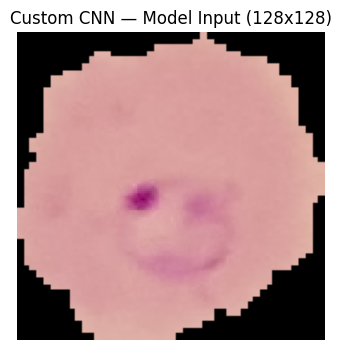

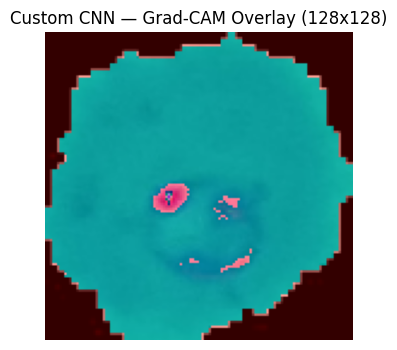

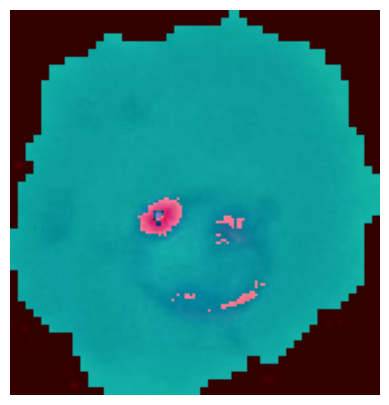

In [12]:
img_path = "/content/sample_images/C100P61ThinF_IMG_20150918_144104_cell_162.png"

show_gradcam_for_model(img_path, custom_cnn_model, "conv2d_1", "Custom CNN")

## Grad-CAM Overlay for MobileNetV2 Frozen Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
--- MobileNetV2 Frozen Model ---
Prediction: Uninfected (0.97 confidence)



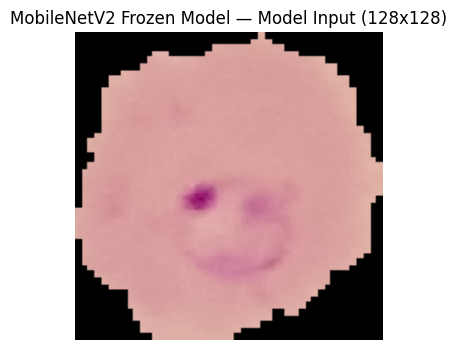

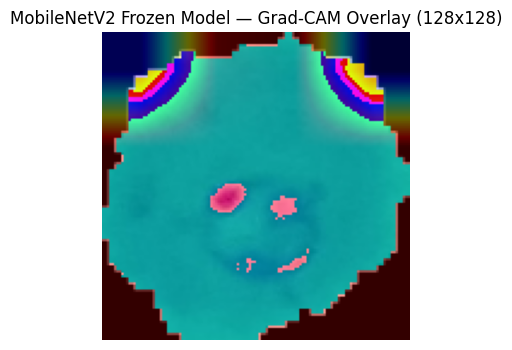

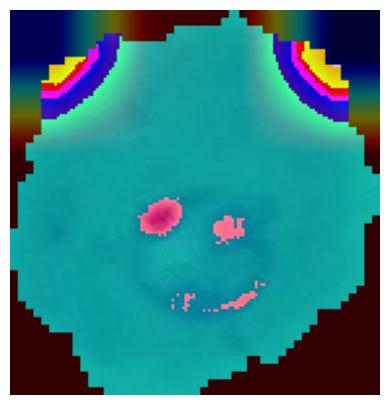

In [13]:
show_gradcam_for_model(img_path, mobilenetv2_frozen_model, "Conv_1", "MobileNetV2 Frozen Model")

## Grad-CAM Overlay for MobileNetV2 Fine-tuned Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
--- MobileNetV2 Fine-tuned Model ---
Prediction: Uninfected (0.89 confidence)



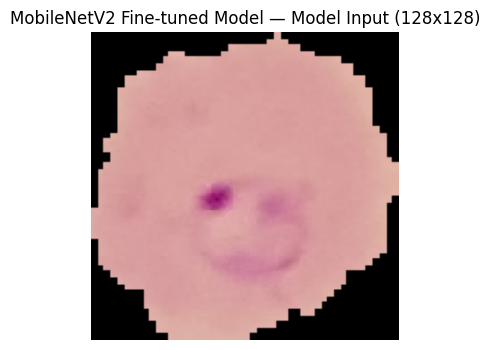

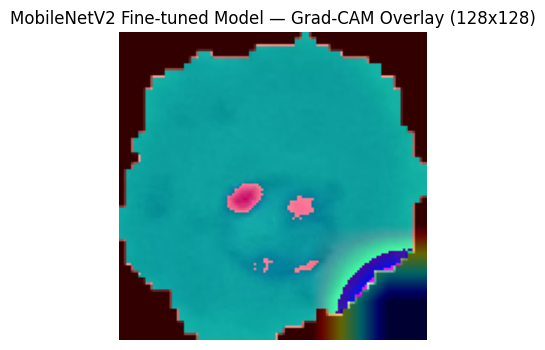

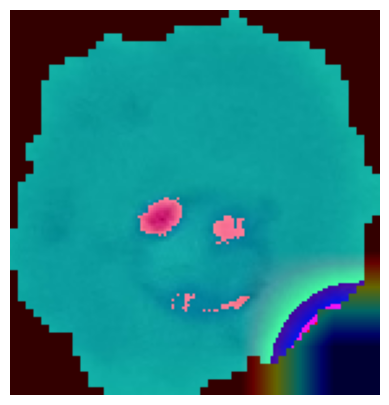

In [14]:
show_gradcam_for_model(img_path, mobilenetv2_finetuned_model, "Conv_1", "MobileNetV2 Fine-tuned Model")